# House Price Prediction - Data Preprocessing and Feature Engineering

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### 2. Load the data

In [4]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(train_data.head())

Training data shape: (1460, 81)
Test data shape: (1459, 80)

First 5 rows:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     

### 3. Missing Values and Target Distribution

In [5]:
# Check missing values
print("\nMissing values in training data:")
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

# Target variable analysis
print(f"\nTarget variable (SalePrice) statistics:")
print(train_data['SalePrice'].describe())


Missing values in training data:
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Target variable (SalePrice) statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


### 4. SalePrice Visualization

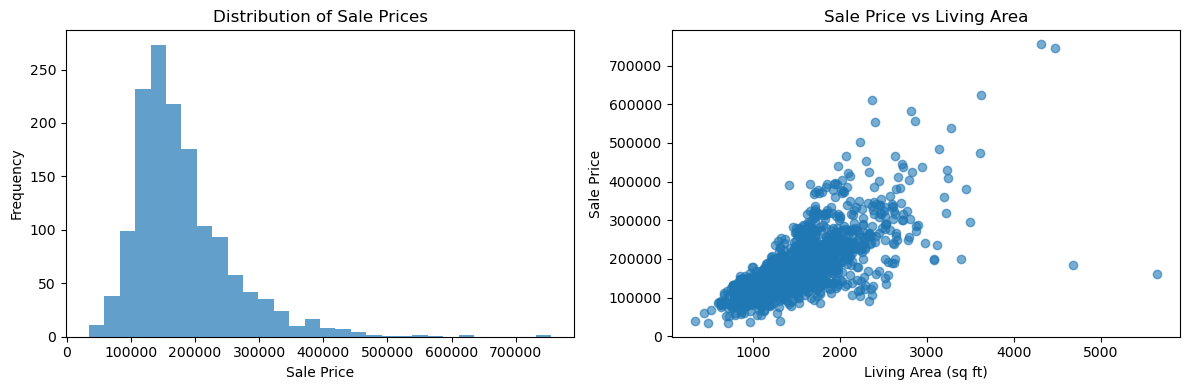

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_data['SalePrice'], bins=30, alpha=0.7)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.scatter(train_data['GrLivArea'], train_data['SalePrice'], alpha=0.6)
plt.title('Sale Price vs Living Area')
plt.xlabel('Living Area (sq ft)')
plt.ylabel('Sale Price')

plt.tight_layout()
plt.show()

### 5. Feature Selection

In [7]:
numerical_features = ['LotArea', 'YearBuilt', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']

categorical_features = ['MSZoning', 'Neighborhood', 'BldgType', 'HouseStyle', 'ExterQual', 'Foundation', 'HeatingQC', 'KitchenQual']

# Create working dataset with selected features
selected_features = numerical_features + categorical_features + ['SalePrice']
work_data = train_data[selected_features].copy()

print(f"Selected {len(numerical_features)} numerical and {len(categorical_features)} categorical features")

Selected 12 numerical and 8 categorical features


### 6. Handling Missing Values

In [8]:
# Fill numerical missing values with median
for col in numerical_features:
    if work_data[col].isnull().sum() > 0:
        work_data[col] = work_data[col].fillna(work_data[col].median())

# Fill categorical missing values with mode
for col in categorical_features:
    if work_data[col].isnull().sum() > 0:
        work_data[col] = work_data[col].fillna(work_data[col].mode()[0])

print(f"Missing values after preprocessing: {work_data.isnull().sum().sum()}")

Missing values after preprocessing: 0


### 7. Feature Engineering

In [9]:
work_data['TotalSF'] = work_data['TotalBsmtSF'] + work_data['1stFlrSF'] + work_data['2ndFlrSF']
work_data['TotalBathrooms'] = work_data['FullBath'] + work_data['HalfBath']

if 'YrSold' in train_data.columns:
    work_data['HouseAge'] = train_data['YrSold'] - work_data['YearBuilt']
else:
    work_data['HouseAge'] = 2023 - work_data['YearBuilt']

work_data['HasGarage'] = (work_data['GarageArea'] > 0).astype(int)
work_data['HasBasement'] = (work_data['TotalBsmtSF'] > 0).astype(int)

print("New features created:")
print("TotalSF: Total square footage")
print("TotalBathrooms: Total number of bathrooms")
print("HouseAge: Age of the house")
print("HasGarage: Binary feature for garage presence")
print("HasBasement: Binary feature for basement presence")

New features created:
TotalSF: Total square footage
TotalBathrooms: Total number of bathrooms
HouseAge: Age of the house
HasGarage: Binary feature for garage presence
HasBasement: Binary feature for basement presence


### 8. Encoding

In [10]:
# Quality features - ordinal encoding
quality_mapping = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
work_data['ExterQual'] = work_data['ExterQual'].map(quality_mapping)
work_data['HeatingQC'] = work_data['HeatingQC'].map(quality_mapping)
work_data['KitchenQual'] = work_data['KitchenQual'].map(quality_mapping)

# Other categorical features - one-hot encoding
categorical_to_encode = ['MSZoning', 'Neighborhood', 'BldgType', 'HouseStyle', 'Foundation']
work_data = pd.get_dummies(work_data, columns=categorical_to_encode, drop_first=True)

print(f"Dataset shape after encoding: {work_data.shape}")

Dataset shape after encoding: (1460, 65)


### 9. PREPARE DATA FOR MODELING

In [11]:
# Separate features and target
X = work_data.drop('SalePrice', axis=1)
y = work_data['SalePrice']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: (1168, 64)
Test set: (292, 64)


### 10. Building and Evaluating Models

In [12]:
# Linear Regression
print("\nLinear Regression:")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print(f"RMSE: ${lr_rmse:,.2f}")
print(f"R2 Score: {lr_r2:.4f}")

# Random Forest
print("\nRandom Forest:")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # Random Forest doesn't need scaling
rf_pred = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"RMSE: ${rf_rmse:,.2f}")
print(f"R2 Score: {rf_r2:.4f}")


Linear Regression:
RMSE: $35,632.81
R2 Score: 0.8345

Random Forest:
RMSE: $30,148.29
R2 Score: 0.8815


### 11. Feature Importance Plot


Top 10 most important features:
        feature  importance
15      TotalSF    0.657249
14  KitchenQual    0.049703
17     HouseAge    0.038896
1     YearBuilt    0.037444
4      2ndFlrSF    0.029434
10   GarageCars    0.025381
0       LotArea    0.023729
12    ExterQual    0.023536
11   GarageArea    0.018719
5     GrLivArea    0.018676


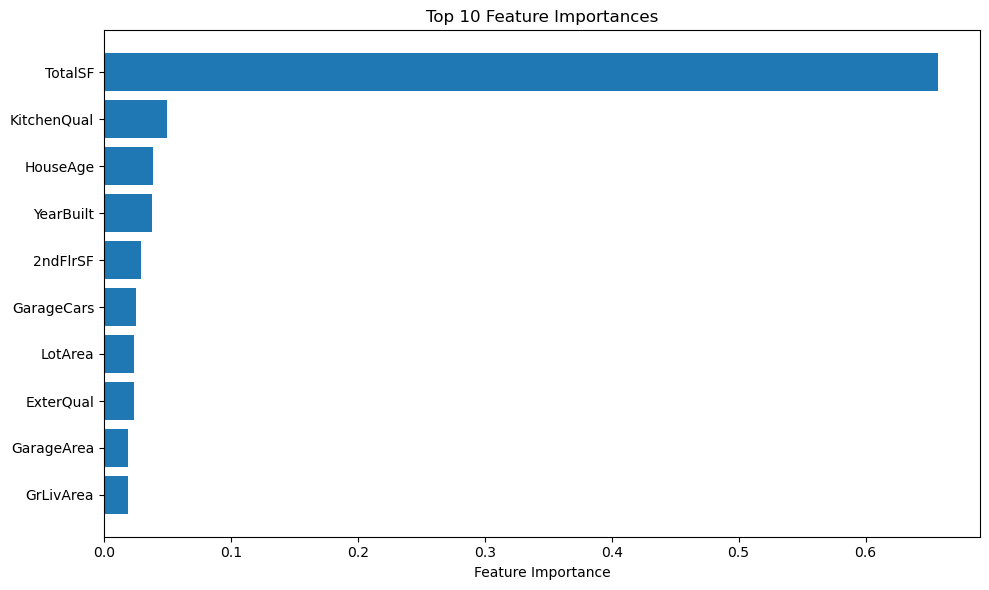

In [13]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 12. Compare models


Model Comparison:
               Model          RMSE  R2 Score
0  Linear Regression  35632.807179  0.834466
1      Random Forest  30148.293530  0.881502


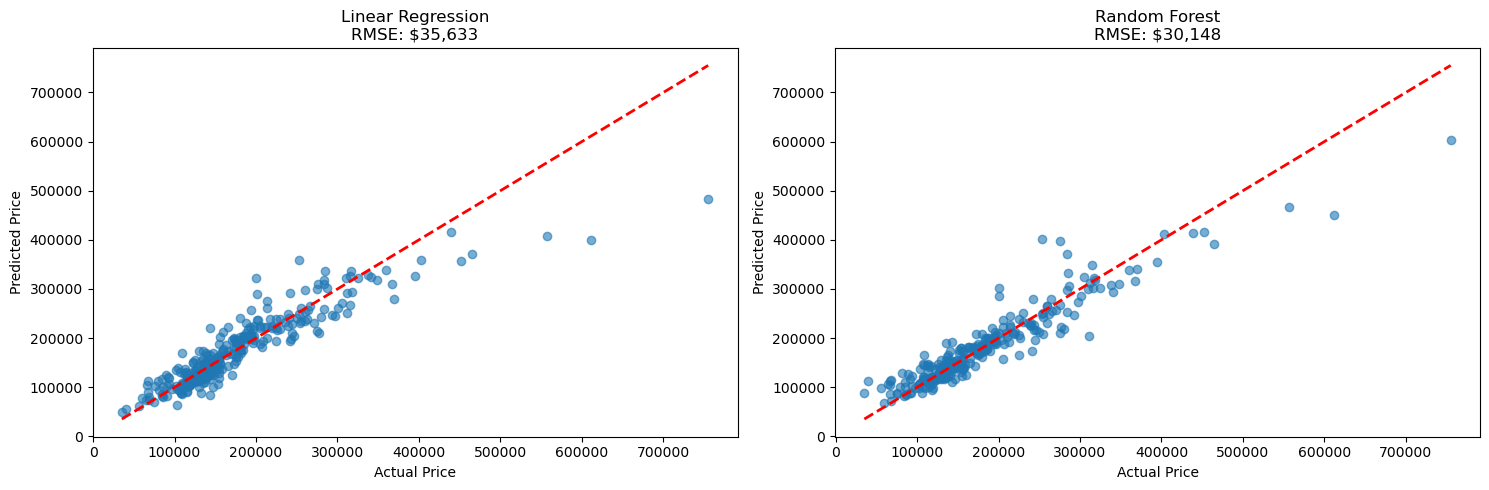

In [15]:
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [lr_rmse, rf_rmse],
    'R2 Score': [lr_r2, rf_r2]
})

print("\nModel Comparison:")
print(models_comparison)

# Plot actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Linear Regression
axes[0].scatter(y_test, lr_pred, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'Linear Regression\nRMSE: ${lr_rmse:,.0f}')

# Random Forest
axes[1].scatter(y_test, rf_pred, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title(f'Random Forest\nRMSE: ${rf_rmse:,.0f}')

plt.tight_layout()
plt.show()

### 13. Summary

In [17]:
print("ASSIGNMENT SUMMARY")

print(f"Dataset loaded: {train_data.shape[0]} houses")
print(f"Features selected: {len(numerical_features + categorical_features)}")
print(f"Missing values handled: Simple imputation")
print(f"New features created: 5 additional features")
print(f"Categorical encoding: Ordinal + One-hot encoding")
print(f"Models trained: Linear Regression, Random Forest")
print(f"Best model: {'Random Forest' if rf_r2 > lr_r2 else 'Linear Regression'}")
print(f"Best R2 Score: {max(lr_r2, rf_r2):.4f}")

print("\nKey Learning Points:")
print("- Data preprocessing is crucial for model performance")
print("- Feature engineering can significantly improve predictions")
print("- Different models perform differently on the same data")
print("- Feature importance helps understand what drives house prices")

print("\nAssignment completed successfully!")

ASSIGNMENT SUMMARY
Dataset loaded: 1460 houses
Features selected: 20
Missing values handled: Simple imputation
New features created: 5 additional features
Categorical encoding: Ordinal + One-hot encoding
Models trained: Linear Regression, Random Forest
Best model: Random Forest
Best R2 Score: 0.8815

Key Learning Points:
- Data preprocessing is crucial for model performance
- Feature engineering can significantly improve predictions
- Different models perform differently on the same data
- Feature importance helps understand what drives house prices

Assignment completed successfully!
